In [412]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import fbeta_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from catboost import CatBoostClassifier
import category_encoders as ce
import torch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')

## Dislocations

In [2]:
dsl = pd.read_csv('DSL_2021_08.csv')

In [3]:
dsl.head()

,carNum,operDate,operCode,operSt,operDestSt,operCargo,operWeight
0,92806595,2021-08-26 08:05:00,ПРИБ,140,13094,00300,16.0
1,97897698,2021-08-26 08:05:00,ПРИБ,140,13094,00300,17.0
2,98097207,2021-08-26 08:05:00,ПРИБ,140,13094,00300,24.0
3,92668896,2021-08-26 08:05:00,ПРИБ,140,13094,00300,25.0
4,94588092,2021-08-26 08:05:00,ПРИБ,140,13094,00300,26.0


In [4]:
dsl = dsl.rename(columns = {'operDate':'repBeginDate'})

In [5]:
dsl.shape

(5061934, 7)

In [6]:
timeArray1 = np.array(list(map(lambda x: pd.Timestamp(x).date(), dsl['repBeginDate'])))

In [7]:
dsl['repBeginDate'] = timeArray1

In [8]:
dsl

,carNum,repBeginDate,operCode,operSt,operDestSt,operCargo,operWeight
0,92806595,2021-08-26,ПРИБ,140,13094,00300,16.0
1,97897698,2021-08-26,ПРИБ,140,13094,00300,17.0
2,98097207,2021-08-26,ПРИБ,140,13094,00300,24.0
3,92668896,2021-08-26,ПРИБ,140,13094,00300,25.0
4,94588092,2021-08-26,ПРИБ,140,13094,00300,26.0
...,...,...,...,...,...,...,...
5061929,98198518,2021-08-17,ОТПР,96342,23060,00300,20.0
5061930,54961453,2021-08-17,ОТПР,96342,23060,00300,21.0
5061931,92630698,2021-08-17,ОТПР,96342,23060,00300,21.0
5061932,92870690,2021-08-17,ОТПР,96342,23060,00300,21.0


In [17]:
dsl = dsl[dsl['carNum'].isin(dsl['carNum'].value_counts().index[dsl['carNum'].value_counts() >= 5])]

In [18]:
dsl['carNum'].value_counts()

92694199    1329
94584091    1302
98191554    1302
92873397    1302
92658699    1302
            ... 
98077720       5
29446796       5
29434990       5
98110018       5
68262765       5
Name: carNum, Length: 16066, dtype: int64

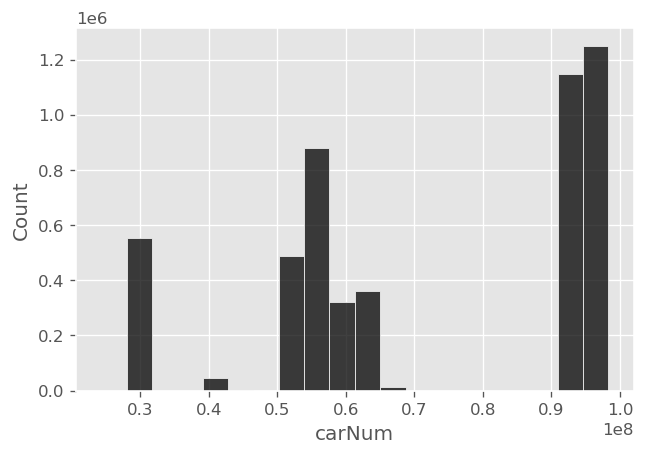

In [33]:
plt.subplots(dpi=120)
sns.histplot(dsl['carNum'], bins=20, color='black')
plt.show()

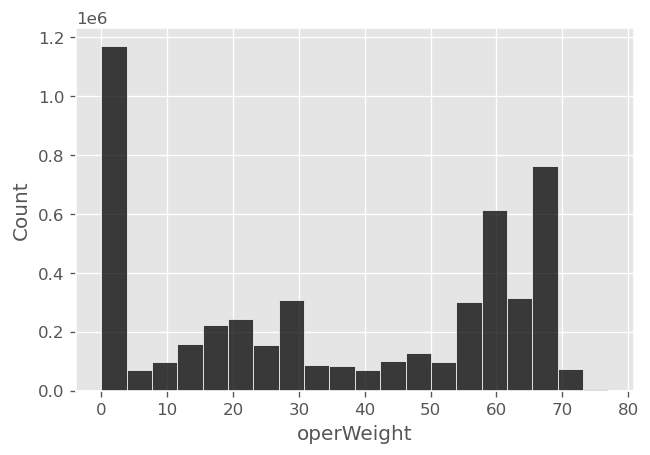

In [32]:
plt.subplots(dpi=120)
sns.histplot(dsl['operWeight'], bins=20, color='black')
plt.show()

In [18]:
dsl['operSt'].value_counts()

18000    20617
85160    17820
3000     16537
30000    16534
85000    15872
         ...  
40750        1
75400        1
38590        1
8000         1
38240        1
Name: operSt, Length: 6143, dtype: int64

In [20]:
dsl['operCargo'].value_counts()

00300    2266538
42103     237165
08118     224000
09111     167518
08103     158209
          ...   
75772          1
51638          1
91118          1
51637          1
75420          1
Name: operCargo, Length: 536, dtype: int64

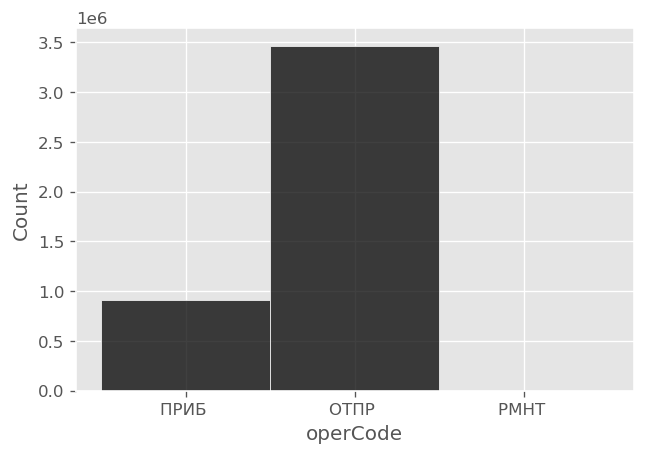

In [59]:
plt.subplots(dpi=120)
sns.histplot(dsl[dsl['operCode'].isin(['ОТПР ', 'ПРИБ ', 'РМНТ '])]['operCode'], bins=20, color='black')
plt.show()

In [60]:
dsl[dsl['operCode'].isin(['ОТПР ', 'ПРИБ ', 'РМНТ '])]['operCode'].value_counts()

ОТПР     3468602
ПРИБ      911984
РМНТ        1642
Name: operCode, dtype: int64

## Repairs

In [34]:
reps = pd.read_csv('Repairs_2021_08-09.csv')

In [35]:
reps['repType'].value_counts()

Текущий        2453
Деповской       515
Разбраковка     336
Капитальный     117
Name: repType, dtype: int64

In [36]:
reps[reps['repType'] == 'Текущий'].head()

,carNum,repType,repBeginDate,repEndDate,repStCode,repRwCode,repStName,repShCode,faultGroup1,faultCode1,faultGroup2,faultCode2,faultGroup3,faultCode3
1,28068658,Текущий,2021-08-01 00:30:00.000,2021-08-03 06:59:00.000,84000,83.0,Алтайская,799,1.0,107,NaN,NaN,NaN,NaN
4,52727617,Текущий,2021-08-02 22:11:00.000,2021-08-03 10:20:00.000,83020,83.0,Входная,4087,5.0,540,NaN,NaN,NaN,NaN
7,61819488,Текущий,2021-09-19 18:38:00.000,2021-09-24 17:51:00.000,29050,28.0,Архангельск-Город,390,1.0,107,NaN,NaN,NaN,NaN
9,61819611,Текущий,2021-08-01 20:53:00.000,2021-08-02 07:48:00.000,83020,83.0,Входная,4087,5.0,540,NaN,NaN,NaN,NaN
10,61819645,Текущий,2021-09-29 16:18:00.000,2021-10-06 17:08:00.000,6150,1.0,Тверь,317,1.0,107,NaN,NaN,NaN,NaN


In [37]:
flanges = pd.read_csv('Flanges_2018-2021.csv', sep=';')

In [38]:
flanges = flanges.dropna()

In [39]:
flanges = flanges.rename(columns = {'carnum': 'carNum','msr_date':'repBeginDate'})

In [40]:
flanges

,carNum,repBeginDate,axle1_rf,axle1_lf,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf
0,28065977,2018-01-29 17:38:00.000,27.8,25.6,26.9,27.1,27.3,25.7,27.1,25.8
1,28070084,2018-01-29 10:38:00.000,26.7,29.7,28.8,28.5,26.0,26.6,26.4,29.5
2,28073328,2018-01-29 17:38:00.000,28.2,27.3,27.1,29.8,23.9,27.1,29.3,26.9
3,29307493,2018-01-29 08:06:00.000,26.2,28.4,27.2,25.5,29.7,29.6,27.6,27.8
4,29376894,2018-01-29 21:12:00.000,27.2,27.4,26.4,26.0,26.1,27.8,28.8,28.4
...,...,...,...,...,...,...,...,...,...,...
1035453,61818571,2021-11-08 21:53:00.000,26.9,26.8,28.8,27.6,25.4,28.2,27.4,26.8
1035454,61601563,2021-11-08 21:57:00.000,27.5,27.3,25.0,28.3,28.0,27.4,25.3,28.0
1035455,61554986,2021-11-08 22:27:00.000,26.0,26.5,28.3,27.0,30.4,29.5,30.3,29.8
1035458,61434866,2021-11-08 23:27:00.000,27.2,28.1,27.2,25.5,28.0,27.7,25.6,26.8


In [41]:
flanges['repBeginDate'] = np.array(list(map(lambda x: pd.Timestamp(x).date(), flanges['repBeginDate'])))

In [42]:
flanges

,carNum,repBeginDate,axle1_rf,axle1_lf,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf
0,28065977,2018-01-29,27.8,25.6,26.9,27.1,27.3,25.7,27.1,25.8
1,28070084,2018-01-29,26.7,29.7,28.8,28.5,26.0,26.6,26.4,29.5
2,28073328,2018-01-29,28.2,27.3,27.1,29.8,23.9,27.1,29.3,26.9
3,29307493,2018-01-29,26.2,28.4,27.2,25.5,29.7,29.6,27.6,27.8
4,29376894,2018-01-29,27.2,27.4,26.4,26.0,26.1,27.8,28.8,28.4
...,...,...,...,...,...,...,...,...,...,...
1035453,61818571,2021-11-08,26.9,26.8,28.8,27.6,25.4,28.2,27.4,26.8
1035454,61601563,2021-11-08,27.5,27.3,25.0,28.3,28.0,27.4,25.3,28.0
1035455,61554986,2021-11-08,26.0,26.5,28.3,27.0,30.4,29.5,30.3,29.8
1035458,61434866,2021-11-08,27.2,28.1,27.2,25.5,28.0,27.7,25.6,26.8


In [43]:
parts = pd.read_csv('Parts_2018-2021.csv')

In [44]:
parts.head()

,carNum,repDate,repShop,partType,partMountShop,partMountDt,partManufactureShop,partManufactureYear,partRimDepth,partFlangeDepth
0,24557720,2018-04-17,4100,БАЛКА,4100,2018-04-17,14.0,1994.0,0.0,0.0
1,24557720,2018-04-17,4100,БАЛКА,4100,2018-04-17,14.0,1993.0,0.0,0.0
2,24557720,2018-04-17,4100,ОСЬ,4100,2018-04-17,5.0,1986.0,43.0,30.0
3,24557720,2018-04-17,4100,ОСЬ,4100,2018-04-17,5.0,2008.0,32.0,30.0
4,24557720,2018-04-17,4100,ОСЬ,4100,2018-04-17,5.0,2007.0,35.0,30.0


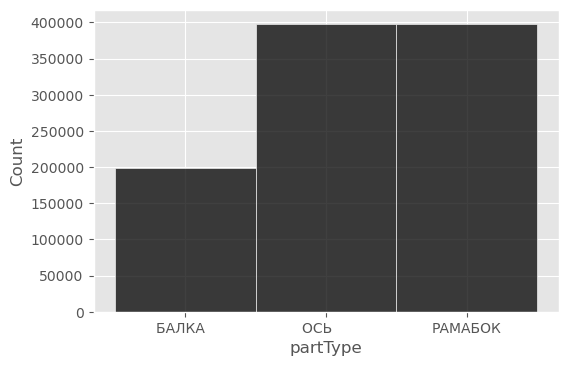

In [48]:
plt.subplots(dpi=100)
sns.histplot(parts['partType'], bins=20, color='black')
plt.show()

In [61]:
parts['partType'].value_counts()

ОСЬ        397746
РАМАБОК    397746
БАЛКА      198873
Name: partType, dtype: int64

In [62]:
dslFlanges = pd.merge(dsl, flanges, how='inner', on=['carNum', 'repBeginDate'])

In [63]:
dslFlanges[dslFlanges['operCode'] == 'РМНТ ']

,carNum,repBeginDate,operCode,operSt,operDestSt,operCargo,operWeight,axle1_rf,axle1_lf,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf
30,61523155,2021-08-17,РМНТ,17000,29040,25313,69.0,28.7,29.7,31.1,29.8,28.9,30.1,30.4,28.0
3675,61555017,2021-08-19,РМНТ,17000,18340,23245,68.0,30.7,30.8,29.6,29.4,29.8,29.8,30.7,29.9
4800,29330891,2021-08-13,РМНТ,28000,28410,30324,0.0,25.9,27.5,24.3,27.0,24.1,24.9,25.6,30.2
4801,29330891,2021-08-13,РМНТ,28000,28410,30324,0.0,25.9,27.5,24.3,27.0,24.1,24.9,25.6,30.2
4802,29330891,2021-08-13,РМНТ,28000,28410,30324,0.0,25.9,27.5,24.3,27.0,24.1,24.9,25.6,30.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780452,54235585,2021-08-28,РМНТ,94310,92390,09111,0.0,29.1,30.1,31.2,30.8,28.4,29.5,23.2,32.7
785059,52910676,2021-08-30,РМНТ,22000,64820,23508,0.0,27.2,27.7,29.8,30.3,27.4,27.9,28.8,27.5
788074,52790482,2021-08-25,РМНТ,90440,92450,16118,0.0,24.6,27.8,29.8,29.3,26.2,28.6,28.0,28.8
788075,52790482,2021-08-25,РМНТ,90440,92450,16118,0.0,24.6,27.8,29.8,29.3,26.2,28.6,28.0,28.8


In [64]:
dslFlanges.shape

(788579, 15)

In [65]:
res = pd.read_csv('DislocRepParts.csv')

In [66]:
res['repBeginDate'] = np.array(list(map(lambda x: pd.Timestamp(x).date(), res['repBeginDate'])))

In [67]:
res

,carNum,repBeginDate,operCode,repStCode,operDestSt,operCargo,operWeight,repType,partRimDepth,partFlangeDepth,partType_БАЛКА,partType_ОСЬ,partType_РАМАБОК
0,29344793,2018-01-01,ОТПР,84080.0,64850,69322,66.0,0,0.0,0.0,0.0,0.0,0.0
1,52917028,2018-01-01,ОТПР,30010.0,28410,30411,0.0,0,0.0,0.0,0.0,0.0,0.0
2,56627227,2018-01-01,ОТПР,60840.0,40490,16118,70.0,0,0.0,0.0,0.0,0.0,0.0
3,29344793,2018-01-01,ОТПР,83680.0,64850,69322,66.0,0,0.0,0.0,0.0,0.0,0.0
4,52917028,2018-01-01,ОТПР,30110.0,28410,30411,0.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329981,53586186,2019-08-31,ОТПР,86480.0,59220,16104,68.0,0,0.0,0.0,0.0,0.0,0.0
2329982,54260096,2019-08-31,ПРИБ,93480.0,93730,300,59.0,0,25.9,12.0,2.0,4.0,4.0
2329983,28832566,2019-09-01,ОТПР,27781.0,74560,12202,67.0,0,0.0,0.0,0.0,0.0,0.0
2329984,28067320,2019-09-01,ОТПР,20820.0,20890,24211,0.0,0,13.7,12.0,2.0,4.0,4.0


In [68]:
data = pd.merge(res, flanges, how='left', on=['carNum', 'repBeginDate']).drop_duplicates()

In [69]:
data.head()

,carNum,repBeginDate,operCode,repStCode,operDestSt,operCargo,operWeight,repType,partRimDepth,partFlangeDepth,...,partType_ОСЬ,partType_РАМАБОК,axle1_rf,axle1_lf,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf
0,29344793,2018-01-01,ОТПР,84080.0,64850,69322,66.0,0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52917028,2018-01-01,ОТПР,30010.0,28410,30411,0.0,0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56627227,2018-01-01,ОТПР,60840.0,40490,16118,70.0,0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29344793,2018-01-01,ОТПР,83680.0,64850,69322,66.0,0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52917028,2018-01-01,ОТПР,30110.0,28410,30411,0.0,0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
data.shape

(2243852, 21)

In [71]:
data.dtypes

carNum                int64
repBeginDate         object
operCode             object
repStCode           float64
operDestSt            int64
operCargo             int64
operWeight          float64
repType               int64
partRimDepth        float64
partFlangeDepth     float64
partType_БАЛКА      float64
partType_ОСЬ        float64
partType_РАМАБОК    float64
axle1_rf            float64
axle1_lf            float64
axle2_rf            float64
axle2_lf            float64
axle3_rf            float64
axle3_lf            float64
axle4_rf            float64
axle4_lf            float64
dtype: object

In [72]:
# repeatedReps = pd.concat([data[data['repType'] == 1]]*4)
# data = pd.concat([data, repeatedReps])

In [73]:
ord_enc = OrdinalEncoder()
scaler = MinMaxScaler()

In [74]:
columns = ['operCargo', 'repStCode', 'operDestSt', 'carNum']

In [75]:
data[columns] = data[columns].astype(str)

In [76]:
X = data[['operCargo', 'repStCode', 'operWeight', 'operDestSt', 'carNum', 'partRimDepth',\
               'partFlangeDepth', 'partType_БАЛКА', 'partType_ОСЬ', 'partType_РАМАБОК', 
                'axle1_rf', 'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf',\
                'axle3_lf', 'axle4_rf', 'axle4_lf']]

In [77]:
# for i in columns:
#     ord_enc = OrdinalEncoder()
#     X = X.join(pd.DataFrame(ord_enc.fit_transform(X[[i]]), columns=[i+'1']))

In [78]:
y = data['repType']

In [79]:
for i in columns:
    ord_enc = ce.CatBoostEncoder()
    X[[i]] = ord_enc.fit_transform(X[[i]], y)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [80]:
columns_train = ['operCargo1', 'repStCode1', 'operDestSt1', 'operWeight', 'carNum1', 'partRimDepth',\
               'partFlangeDepth', 'partType_БАЛКА', 'partType_ОСЬ', 'partType_РАМАБОК', \
                'axle1_rf', 'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf',\
                'axle3_lf', 'axle4_rf', 'axle4_lf']

In [81]:
X['operWeight'] = scaler.fit_transform(X[['operWeight']])

<ipython-input-81-427663e937a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['operWeight'] = scaler.fit_transform(X[['operWeight']])


In [82]:
# X = X[columns_train]
X = X.interpolate()
X[['axle1_rf', 'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 'axle4_rf', 'axle4_lf']]=\
    X[['axle1_rf', 'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf',\
                'axle3_lf', 'axle4_rf', 'axle4_lf']].fillna({'axle1_rf': np.mean(X['axle1_rf']),\
                'axle1_lf': np.mean(X['axle1_lf']), 'axle2_rf': np.mean(X['axle2_rf']),\
                'axle2_lf': np.mean(X['axle2_lf']), 'axle3_rf': np.mean(X['axle3_rf']),\
                'axle3_lf': np.mean(X['axle3_lf']), 'axle4_rf': np.mean(X['axle4_rf']),\
                'axle4_lf': np.mean(X['axle4_lf'])})

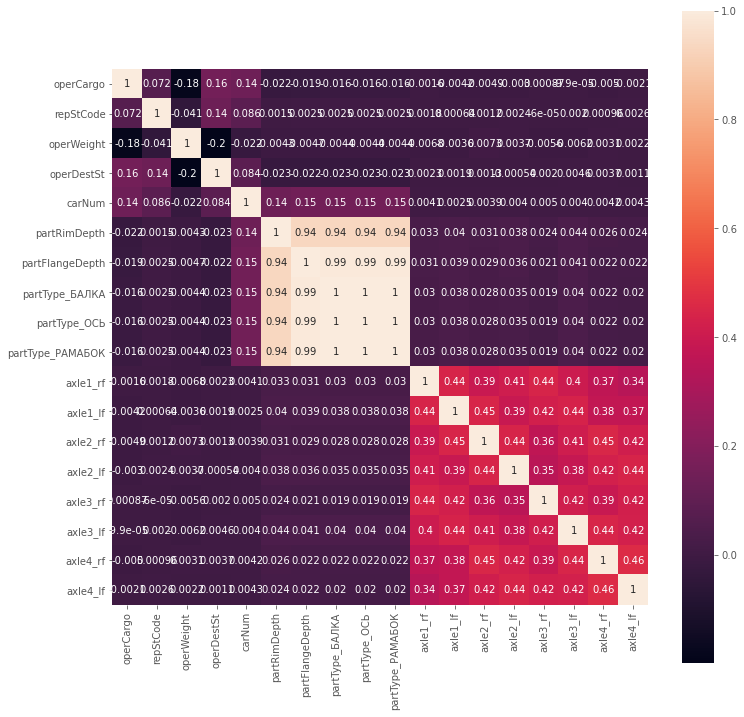

In [83]:
plt.subplots(figsize=(12, 12))
sns.heatmap(X.corr(), annot=True, square=True)
plt.show()

In [84]:
X.head()

,operCargo,repStCode,operWeight,operDestSt,carNum,partRimDepth,partFlangeDepth,partType_БАЛКА,partType_ОСЬ,partType_РАМАБОК,axle1_rf,axle1_lf,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf
0,0.00166,0.00166,0.868421,0.00166,0.00166,0.0,0.0,0.0,0.0,0.0,28.078406,28.159313,28.18709,28.181189,28.039307,28.128573,28.209754,28.177149
1,0.00166,0.00166,0.000000,0.00166,0.00166,0.0,0.0,0.0,0.0,0.0,28.078406,28.159313,28.18709,28.181189,28.039307,28.128573,28.209754,28.177149
2,0.00166,0.00166,0.921053,0.00166,0.00166,0.0,0.0,0.0,0.0,0.0,28.078406,28.159313,28.18709,28.181189,28.039307,28.128573,28.209754,28.177149
3,0.00083,0.00166,0.868421,0.00083,0.00083,0.0,0.0,0.0,0.0,0.0,28.078406,28.159313,28.18709,28.181189,28.039307,28.128573,28.209754,28.177149
4,0.00083,0.00166,0.000000,0.00083,0.00083,0.0,0.0,0.0,0.0,0.0,28.078406,28.159313,28.18709,28.181189,28.039307,28.128573,28.209754,28.177149


In [85]:
inds = X.index

In [86]:
Y = data['repType']

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False, random_state=5)

### Logistic Regression

In [88]:
logReg = LogisticRegression(max_iter = 2000, class_weight='balanced')

In [89]:
logReg.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

In [90]:
prediction = logReg.predict(X_test)

In [91]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91    739262
           1       0.01      0.85      0.02      1210

    accuracy                           0.83    740472
   macro avg       0.50      0.84      0.46    740472
weighted avg       1.00      0.83      0.90    740472



In [92]:
print(confusion_matrix(Y_test, prediction))

[[611451 127811]
 [   184   1026]]


In [93]:
data['axle2_rf'].value_counts().sum()

260896

In [326]:
probs = pd.DataFrame(logReg.predict_proba(X_test), columns=['0', '1'])
probs['prediction'] = 0
probs['prediction'].iloc[np.where(probs['1'] > 0.45)] = 1

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [327]:
probs.head()

,0,1,prediction
0,0.921543,0.078457,0
1,0.749947,0.250053,0
2,0.966881,0.033119,0
3,0.943636,0.056364,0
4,0.895207,0.104793,0


In [328]:
print(confusion_matrix(Y_test, probs['prediction'].values))

[[597972 141290]
 [   143   1067]]


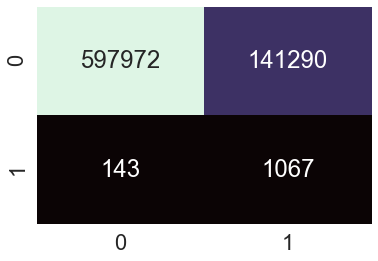

In [369]:
# plt.subplots(dpi=50)
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test, probs['prediction'].values), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

In [329]:
roc_lr = roc_curve(Y_test, logReg.predict_proba(X_test)[:, 1])

In [330]:
fbeta_lr = fbeta_score(Y_test, probs['prediction'].values, average='weighted', beta=2)
fbeta_lr

0.8396759442922523

### Random Forest Classifier

In [99]:
rf_cls = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state=5, bootstrap=True, oob_score=True,\
                                     class_weight='balanced_subsample', n_jobs=-1)
rf_cls.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_jobs=-1, oob_score=True, random_state=5)

In [100]:
print(classification_report(Y_test, rf_cls.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    739262
           1       0.04      0.85      0.08      1210

    accuracy                           0.97    740472
   macro avg       0.52      0.91      0.53    740472
weighted avg       1.00      0.97      0.98    740472



In [101]:
print(confusion_matrix(Y_test, rf_cls.predict(X_test)))

[[715379  23883]
 [   182   1028]]


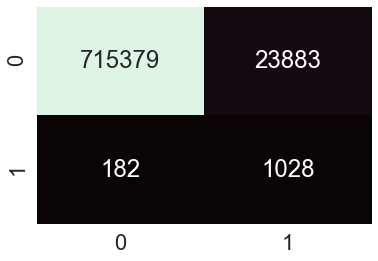

In [368]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test, rf_cls.predict(X_test)), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

In [102]:
feature_imp = pd.Series(rf_cls.feature_importances_, index=X.columns).sort_values(ascending=False)

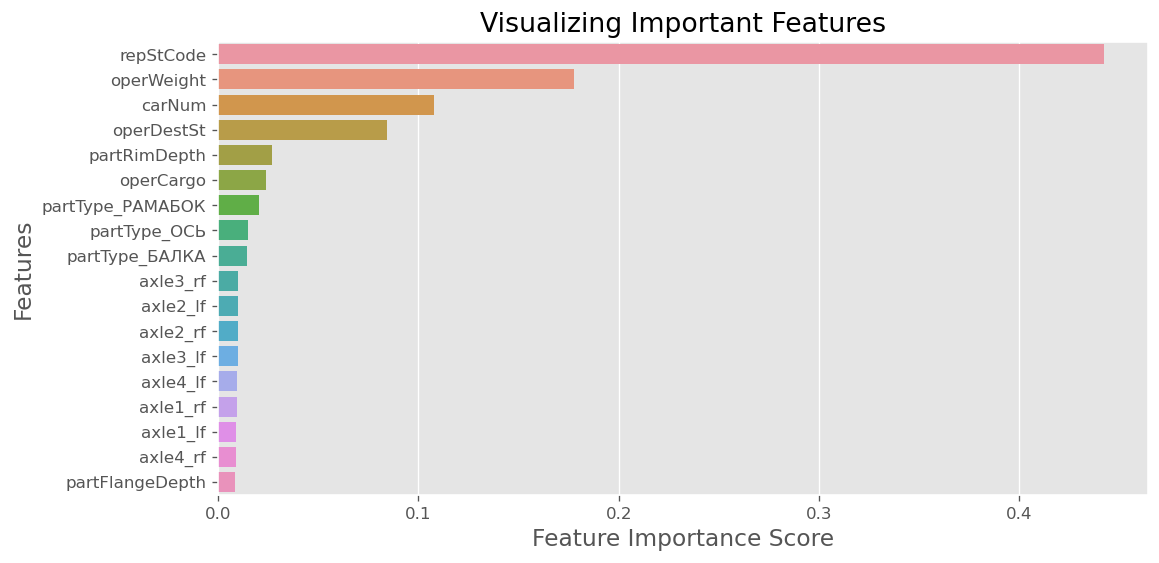

In [103]:
plt.figure(figsize=(10,5), dpi=120)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title("Visualizing Important Features", fontsize=16)
plt.show()

In [104]:
roc_rf = roc_curve(Y_test, rf_cls.predict_proba(X_test)[:, 1])

In [317]:
fbeta_rf = fbeta_score(Y_test, rf_cls.predict(X_test), average='weighted', beta=2)
fbeta_rf

0.9726292301736386

### Gradient Boost Classifier

In [106]:
gboost = GradientBoostingClassifier(n_estimators=100, random_state=10, max_depth=3, learning_rate=0.1, max_features='sqrt')
gboost.fit(X_train, Y_train)

GradientBoostingClassifier(max_features='sqrt', random_state=10)

In [107]:
print(classification_report(Y_test, gboost.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    739262
           1       0.53      0.38      0.44      1210

    accuracy                           1.00    740472
   macro avg       0.76      0.69      0.72    740472
weighted avg       1.00      1.00      1.00    740472



In [108]:
print(confusion_matrix(Y_test, gboost.predict(X_test)))

[[738851    411]
 [   755    455]]


In [109]:
roc_gb = roc_curve(Y_test, gboost.predict_proba(X_test)[:, 1])

In [316]:
fbeta_gb = fbeta_score(Y_test, gboost.predict(X_test), average='weighted', beta=2)
fbeta_gb

0.9983695202835927

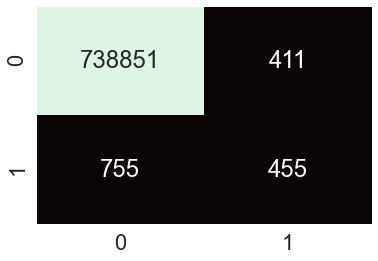

In [367]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test, gboost.predict(X_test)), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

### AdaBoost based on Random Forest

In [418]:
adaboost = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100, max_depth = 10, \
                    random_state=5, bootstrap=True, oob_score=True,\
                    class_weight='balanced_subsample', n_jobs=-1), 
                              
                    n_estimators=10, random_state=5)

adaboost.fit(X_train, Y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                         max_depth=10,
                                                         n_jobs=-1,
                                                         oob_score=True,
                                                         random_state=5),
                   n_estimators=10, random_state=5)

In [419]:
print(classification_report(Y_test, adaboost.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    739262
           1       0.12      0.71      0.21      1210

    accuracy                           0.99    740472
   macro avg       0.56      0.85      0.60    740472
weighted avg       1.00      0.99      0.99    740472



In [420]:
print(confusion_matrix(Y_test, adaboost.predict(X_test)))

[[733077   6185]
 [   350    860]]


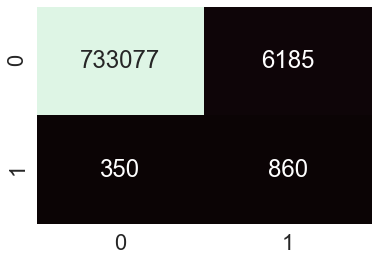

In [421]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test, adaboost.predict(X_test)), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

In [422]:
roc_abrf = roc_curve(Y_test, adaboost.predict_proba(X_test)[:, 1])

In [423]:
fbeta_abrf = fbeta_score(Y_test, adaboost.predict(X_test), average='weighted', beta=2)
fbeta_abrf

0.9921696495836316

### AdaBoost based on Gradient Boosting

In [149]:
adaboost_GB = AdaBoostClassifier(base_estimator=GradientBoostingClassifier(n_estimators=50, \
                                            random_state=5, max_depth=5, learning_rate=0.1, max_features='sqrt'),
                                n_estimators=10, random_state=5)

adaboost_GB.fit(X_train, Y_train)

AdaBoostClassifier(base_estimator=GradientBoostingClassifier(max_depth=5,
                                                             max_features='sqrt',
                                                             n_estimators=50,
                                                             random_state=5),
                   n_estimators=10, random_state=5)

In [150]:
print(classification_report(Y_test, adaboost_GB.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    739262
           1       0.44      0.39      0.41      1210

    accuracy                           1.00    740472
   macro avg       0.72      0.69      0.71    740472
weighted avg       1.00      1.00      1.00    740472



In [151]:
print(confusion_matrix(Y_test, adaboost_GB.predict(X_test)))

[[738675    587]
 [   740    470]]


In [153]:
roc_abgb = roc_curve(Y_test, adaboost_GB.predict_proba(X_test)[:, 1])

### Models Blending

In [116]:
voting = VotingClassifier(estimators=[('lr', logReg), ('rfc', rf_cls), ('gboost', gboost)], voting='soft')

In [117]:
voting.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=2000)),
                             ('rfc',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=10, n_jobs=-1,
                                                     oob_score=True,
                                                     random_state=5)),
                             ('gboost',
                              GradientBoostingClassifier(max_features='sqrt',
                                                         random_state=10))],
                 voting='soft')

In [118]:
prediction_voting = voting.predict(X_test)

In [119]:
print(classification_report(Y_test, prediction_voting))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    739262
           1       0.08      0.72      0.14      1210

    accuracy                           0.99    740472
   macro avg       0.54      0.85      0.57    740472
weighted avg       1.00      0.99      0.99    740472



In [120]:
print(confusion_matrix(Y_test, prediction_voting))

[[729274   9988]
 [   339    871]]


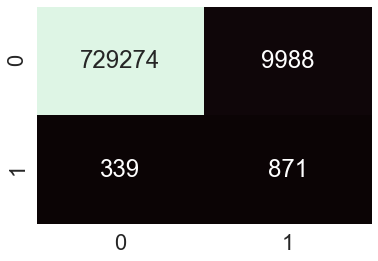

In [370]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test, prediction_voting), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

In [121]:
prediction_voting

array([0, 0, 0, ..., 0, 0, 0])

In [122]:
roc_voting = roc_curve(Y_test, voting.predict_proba(X_test)[:, 1])

In [314]:
fbeta_vote1 = fbeta_score(Y_test, voting.predict(X_test), average='weighted', beta=2)
fbeta_vote1

0.987908213942037

### Cat Boost Classifier

In [124]:
X2 = data[['operCargo', 'repStCode', 'operWeight', 'operDestSt', 'carNum', 'partRimDepth',\
               'partFlangeDepth', 'partType_БАЛКА', 'partType_ОСЬ', 'partType_РАМАБОК', 
                'axle1_rf', 'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf',\
                'axle3_lf', 'axle4_rf', 'axle4_lf']]

In [125]:
y2 = data['repType']

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=0.33, shuffle=False, random_state=5)

In [126]:
cbc = CatBoostClassifier(learning_rate=1, depth=3, loss_function='Logloss', iterations=100)

In [127]:
cbc.fit(X_train2, Y_train2)

0:	learn: 0.1309855	total: 128ms	remaining: 12.7s
1:	learn: 0.0486149	total: 165ms	remaining: 8.09s
2:	learn: 0.0229571	total: 215ms	remaining: 6.95s
3:	learn: 0.0144354	total: 255ms	remaining: 6.11s
4:	learn: 0.0117391	total: 292ms	remaining: 5.54s
5:	learn: 0.0149402	total: 327ms	remaining: 5.12s
6:	learn: 0.0121627	total: 363ms	remaining: 4.83s
7:	learn: 0.0143591	total: 408ms	remaining: 4.69s
8:	learn: 0.0114217	total: 444ms	remaining: 4.49s
9:	learn: 0.0111193	total: 480ms	remaining: 4.32s
10:	learn: 0.0110459	total: 516ms	remaining: 4.18s
11:	learn: 0.0110728	total: 555ms	remaining: 4.07s
12:	learn: 0.0109580	total: 590ms	remaining: 3.95s
13:	learn: 0.0430397	total: 628ms	remaining: 3.86s
14:	learn: 0.0224235	total: 662ms	remaining: 3.75s
15:	learn: 0.0224208	total: 696ms	remaining: 3.65s
16:	learn: 0.0224207	total: 730ms	remaining: 3.56s
17:	learn: 0.0168837	total: 764ms	remaining: 3.48s
18:	learn: 0.0248901	total: 799ms	remaining: 3.41s
19:	learn: 0.0224207	total: 839ms	remaini

In [128]:
print(classification_report(Y_test2, cbc.predict(X_test2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    739262
           1       0.22      0.06      0.10      1210

    accuracy                           1.00    740472
   macro avg       0.61      0.53      0.55    740472
weighted avg       1.00      1.00      1.00    740472



In [129]:
print(confusion_matrix(Y_test2, cbc.predict(X_test2)))

[[739001    261]
 [  1136     74]]


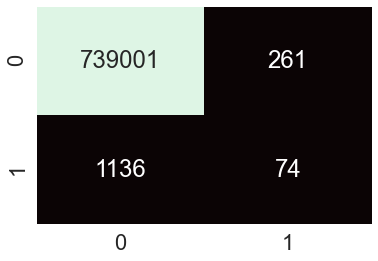

In [371]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test2, cbc.predict(X_test2)), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

In [130]:
roc_catb1 = roc_curve(Y_test2, cbc.predict_proba(X_test2)[:, 1])

In [131]:
cbc2 = CatBoostClassifier(learning_rate=0.1, depth=15, loss_function='Logloss', iterations=100)

In [132]:
cbc2.fit(X_train, Y_train)

0:	learn: 0.5993267	total: 912ms	remaining: 1m 30s
1:	learn: 0.5235164	total: 1.77s	remaining: 1m 27s
2:	learn: 0.4592795	total: 2.49s	remaining: 1m 20s
3:	learn: 0.4050947	total: 3.25s	remaining: 1m 18s
4:	learn: 0.3591564	total: 4s	remaining: 1m 16s
5:	learn: 0.3189562	total: 4.72s	remaining: 1m 13s
6:	learn: 0.2836648	total: 4.79s	remaining: 1m 3s
7:	learn: 0.2538514	total: 5.57s	remaining: 1m 4s
8:	learn: 0.2269064	total: 5.88s	remaining: 59.5s
9:	learn: 0.2034885	total: 6.63s	remaining: 59.7s
10:	learn: 0.1826853	total: 7.38s	remaining: 59.7s
11:	learn: 0.1640501	total: 7.43s	remaining: 54.5s
12:	learn: 0.1475508	total: 7.56s	remaining: 50.6s
13:	learn: 0.1330589	total: 8.3s	remaining: 51s
14:	learn: 0.1200008	total: 8.42s	remaining: 47.7s
15:	learn: 0.1086088	total: 9.16s	remaining: 48.1s
16:	learn: 0.0984923	total: 9.92s	remaining: 48.5s
17:	learn: 0.0891523	total: 10.1s	remaining: 45.9s
18:	learn: 0.0809435	total: 10.9s	remaining: 46.4s
19:	learn: 0.0734294	total: 11.6s	remaini

In [133]:
print(classification_report(Y_test, cbc2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    739262
           1       1.00      0.38      0.55      1210

    accuracy                           1.00    740472
   macro avg       1.00      0.69      0.77    740472
weighted avg       1.00      1.00      1.00    740472



In [134]:
print(confusion_matrix(Y_test, cbc2.predict(X_test)))

[[739260      2]
 [   751    459]]


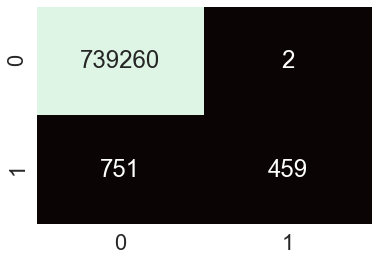

In [372]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test, cbc2.predict(X_test)), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

In [135]:
roc_catb2 = roc_curve(Y_test, cbc2.predict_proba(X_test)[:, 1])

In [313]:
fbeta_cb = fbeta_score(Y_test, cbc2.predict(X_test), average='weighted', beta=2)
fbeta_cb

0.9988684038606477

### Model Blending 2.0

In [374]:
voting2 = VotingClassifier(estimators=[('lr', logReg), ('adaboost', adaboost), ('catboost', cbc2)], voting='soft')

In [375]:
voting2.fit(X_train, Y_train)

0:	learn: 0.5993267	total: 1.02s	remaining: 1m 40s
1:	learn: 0.5235164	total: 1.87s	remaining: 1m 31s
2:	learn: 0.4592795	total: 2.69s	remaining: 1m 26s
3:	learn: 0.4050947	total: 3.49s	remaining: 1m 23s
4:	learn: 0.3591564	total: 4.27s	remaining: 1m 21s
5:	learn: 0.3189562	total: 4.94s	remaining: 1m 17s
6:	learn: 0.2836648	total: 5.03s	remaining: 1m 6s
7:	learn: 0.2538514	total: 5.79s	remaining: 1m 6s
8:	learn: 0.2269064	total: 6.13s	remaining: 1m 2s
9:	learn: 0.2034885	total: 6.83s	remaining: 1m 1s
10:	learn: 0.1826853	total: 7.5s	remaining: 1m
11:	learn: 0.1640501	total: 7.55s	remaining: 55.4s
12:	learn: 0.1475508	total: 7.68s	remaining: 51.4s
13:	learn: 0.1330589	total: 8.36s	remaining: 51.3s
14:	learn: 0.1200008	total: 8.48s	remaining: 48.1s
15:	learn: 0.1086088	total: 9.15s	remaining: 48.1s
16:	learn: 0.0984923	total: 9.88s	remaining: 48.2s
17:	learn: 0.0891523	total: 10s	remaining: 45.7s
18:	learn: 0.0809435	total: 10.8s	remaining: 46s
19:	learn: 0.0734294	total: 11.5s	remaining

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=2000)),
                             ('adaboost',
                              AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                                       max_depth=10,
                                                                                       n_jobs=-1,
                                                                                       oob_score=True,
                                                                                       random_state=5),
                                                 n_estimators=10,
                                                 random_state=5)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7fd

In [376]:
prediction_voting2 = voting2.predict(X_test)

In [377]:
print(classification_report(Y_test, prediction_voting2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    739262
           1       0.21      0.60      0.31      1210

    accuracy                           1.00    740472
   macro avg       0.60      0.80      0.65    740472
weighted avg       1.00      1.00      1.00    740472



In [378]:
print(confusion_matrix(Y_test, prediction_voting2))

[[736463   2799]
 [   482    728]]


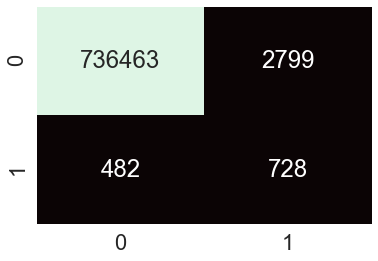

In [379]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(Y_test, prediction_voting2), annot=True, cmap='mako', cbar=False, fmt='d')
plt.show()

In [380]:
roc_voting2 = roc_curve(Y_test, voting2.predict_proba(X_test)[:, 1])

In [381]:
fbeta_vote2 = fbeta_score(Y_test, voting2.predict(X_test), average='weighted', beta=2)
fbeta_vote2

0.9959206241013845

## Roc-Auc 

In [424]:
rocs = [('Logistic regression', roc_lr), ('Random Forest', roc_rf), ('Gradient Boosting', roc_gb),\
        ('AdaBoost ~ RF', roc_abrf), ('CatBoost 1', roc_catb1), ('CatBoost 2', roc_catb2), \
        ('Ensemble 1', roc_voting), ('Ensemble 2', roc_voting2)]

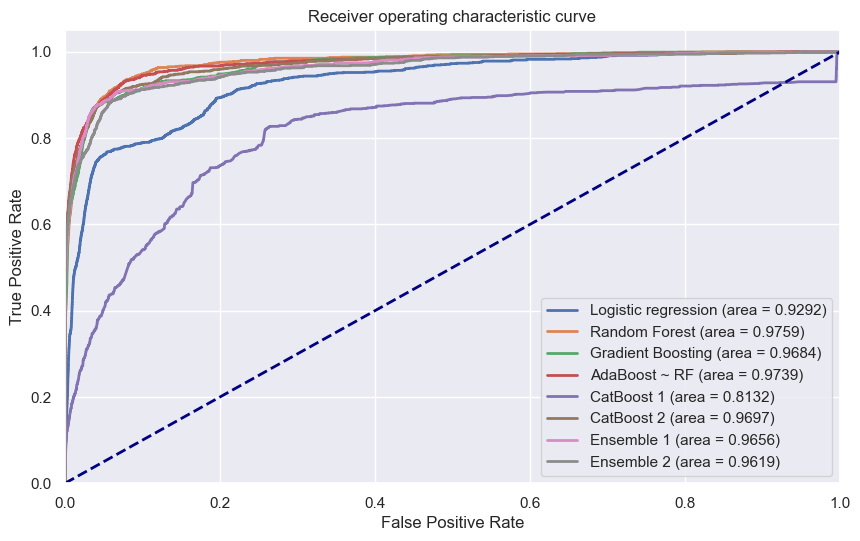

In [425]:
sns.set(font_scale=1)
# plt.style.use('ggplot')
plt.subplots(figsize=(10, 6), dpi=100)




for roc in rocs:
    plt.plot(roc[1][0], roc[1][1], lw=2, label=f"{roc[0]} (area = %0.4f)" % auc(roc[1][0], roc[1][1]))

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()

### F-beta score

In [394]:
fbeta = pd.Series([fbeta_lr, fbeta_rf, fbeta_gb, fbeta_abrf, fbeta_vote1, fbeta_cb, fbeta_vote2],\
                  index=['Log Reg', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Ensemble 1', 'CatBoost', 'Ensemble 2']).sort_values(ascending=False)

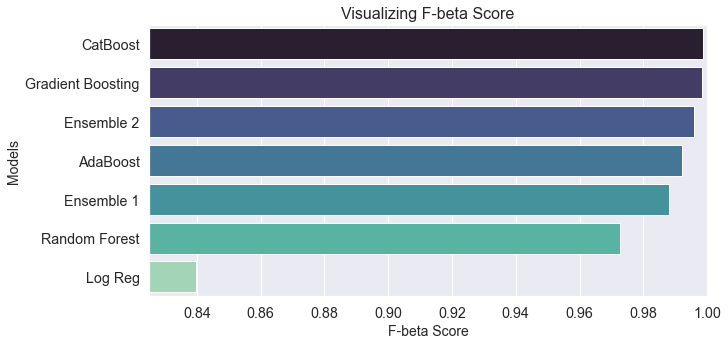

In [395]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.3)
sns.barplot(x=fbeta, y=fbeta.index, palette='mako')

plt.xlabel('F-beta Score', fontsize=14)
plt.xlim(0.825, 1)
plt.ylabel('Models', fontsize=14)
plt.title("Visualizing F-beta Score", fontsize=16)
plt.show()

In [396]:
fbeta

CatBoost             0.998868
Gradient Boosting    0.998370
Ensemble 2           0.995921
AdaBoost             0.992203
Ensemble 1           0.987908
Random Forest        0.972629
Log Reg              0.839676
dtype: float64

# Predictions

In [186]:
X_Prediction = data[data['repBeginDate'] >= pd.Timestamp('2019-08-01')]

In [187]:
X_Prediction2 = X.loc[X_Prediction.index]

In [188]:
res = adaboost.predict_proba(X_Prediction2)

In [189]:
cars = X_Prediction['carNum'].values
stCodes = X_Prediction['repStCode'].values

In [190]:
true_val = X_Prediction['repType']

In [191]:
total_res = pd.DataFrame({'carNum': cars, 'Station': stCodes, 'Probability': res[:, 1], 'Actual': true_val})

In [192]:
total_res = total_res.set_index(['carNum', 'Station']).sort_values(by = 'carNum')

In [193]:
total_res

Probability  Actual
carNum   Station                     
28061984 27200.0     0.450099       0
         76610.0     0.461108       0
         27373.0     0.341475       0
         26700.0     0.393005       0
         27230.0     0.373902       0
...                       ...     ...
98077332 83283.0     0.363245       0
         23060.0     0.536441       0
         25823.0     0.380793       0
         79040.0     0.418214       0
         25442.0     0.386200       0

[692321 rows x 2 columns]

In [195]:
total_res.head(20)

Probability  Actual
carNum   Station                     
28061984 27200.0     0.450099       0
         76610.0     0.461108       0
         27373.0     0.341475       0
         26700.0     0.393005       0
         27230.0     0.373902       0
         76060.0     0.404288       0
         64000.0     0.706840       1
         26720.0     0.359631       0
         27144.0     0.365562       0
         27140.0     0.347639       0
         26600.0     0.400949       0
         26770.0     0.380161       0
         27230.0     0.479093       0
         24580.0     0.371932       0
         26670.0     0.399332       0
         76610.0     0.452493       0
         26670.0     0.367091       0
         27270.0     0.360710       0
         24683.0     0.387688       0
         26770.0     0.341475       0

In [232]:
X_Prediction = data[data['repBeginDate'] >= pd.Timestamp('2019-08-01')]
X_Prediction2 = X.loc[X_Prediction.index]

res = gboost.predict_proba(X_Prediction2)
cars = X_Prediction['carNum'].values
stCodes = X_Prediction['repStCode'].values
true_val = X_Prediction['repType']

total_res = pd.DataFrame({'carNum': cars, 'Station': stCodes, 'Probability': res[:, 1], 'Actual': true_val})
total_res = total_res.set_index(['carNum', 'Station']).sort_values(by = 'carNum')

In [235]:
total_res.head(20)

Probability  Actual
carNum   Station                     
28061984 27200.0     0.000690       0
         76610.0     0.000564       0
         27373.0     0.000094       0
         26700.0     0.000111       0
         27230.0     0.000094       0
         76060.0     0.000562       0
         64000.0     1.000000       1
         26720.0     0.000093       0
         27144.0     0.000106       0
         27140.0     0.000094       0
         26600.0     0.000101       0
         26770.0     0.000095       0
         27230.0     0.000498       0
         24580.0     0.000134       0
         26670.0     0.000106       0
         76610.0     0.000553       0
         26670.0     0.000078       0
         27270.0     0.000095       0
         24683.0     0.000101       0
         26770.0     0.000094       0

In [239]:
X_Prediction = data[data['repBeginDate'] >= pd.Timestamp('2019-08-01')]
X_Prediction2 = X.loc[X_Prediction.index]

res = logReg.predict_proba(X_Prediction2)
cars = X_Prediction['carNum'].values
stCodes = X_Prediction['repStCode'].values
true_val = X_Prediction['repType']

total_res = pd.DataFrame({'carNum': cars, 'Station': stCodes, 'Probability': res[:, 1], 'Actual': true_val})
total_res = total_res.set_index(['carNum', 'Station']).sort_values(by = 'carNum')

In [240]:
total_res.head(20)

Probability  Actual
carNum   Station                     
28061984 27200.0     0.374954       0
         76610.0     0.331884       0
         27373.0     0.047027       0
         26700.0     0.093520       0
         27230.0     0.096537       0
         76060.0     0.316018       0
         64000.0     0.801020       1
         26720.0     0.115795       0
         27144.0     0.115629       0
         27140.0     0.104696       0
         26600.0     0.111136       0
         26770.0     0.106920       0
         27230.0     0.383070       0
         24580.0     0.104734       0
         26670.0     0.109262       0
         76610.0     0.347065       0
         26670.0     0.043959       0
         27270.0     0.102771       0
         24683.0     0.115965       0
         26770.0     0.047035       0